In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def psi(g,e):
    return np.array([g, e])

#def pulse(t, Omega0, delPrime):
#    Omega = np.sqrt(Omega0**2 + delPrime**2)
#    
#    return np.array([[np.cos(Omega*t/2.0) -(1.0j*delPrime/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
#             [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delPrime/Omega)*np.sin(Omega*t/2.0)]])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def phi(psi):
    phi0 = math.atan2(np.real(psi[0]),np.imag(psi[0]))
    phi1 = math.atan2(np.real(psi[1]),np.imag(psi[1]))
    return (phi0-phi1)

def blochVec(psi):
    w = rhogg(psi) - rhoee(psi)  #pointed up is ground state
    if abs(w)>1.0:
        w = float(round(w))
    x = np.sin(np.arccos(w))*np.cos(phi(psi))
    y = np.sin(np.arccos(w))*np.sin(phi(psi))
    return np.array([x,y,w])

def ramsey(psi0, t, delta, delPrime, Omega0):
    #psi0 = initial state vector
    #t = dark time
    #delta = dark time detuning
    #delprime = pulse detuning
    #Omega0 = rabi freq.
    pi2Pulse = pulse(np.pi/(2.0*Omega0), Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(t, 0.0, delta, 0.0, 0.0)
    
    return pi2Pulse@freeEvo@pi2Pulse@psi0

def ramseyInjP(psi0, t, delta, delPrime, Omega0):
    pi2Pulse = pulse(np.pi/(2.0*Omega0), Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(t, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0) 
    
    return pi2Pulse@pi2PhaseInj@freeEvo@pi2Pulse@psi0

def ramseyInjM(psi0, t, delta, delPrime, Omega0):
    pi2Pulse = pulse(np.pi/(2.0*Omega0), Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(t, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0) 
    
    return pi2Pulse@pi2PhaseInj@freeEvo@pi2Pulse@psi0

def errSig(psi0, t, delta, delPrime, Omega0):
    RhoeeP = rhoee(ramseyInjP(psi0,t,delta,delPrime,Omega0))
    RhoeeM = rhoee(ramseyInjM(psi0,t,delta,delPrime,Omega0))
    return RhoeeP - RhoeeM

In [3]:
def hyperRamseyP(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02):
    #pulse(t, Omega0, delta, phi0, phi1):
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(t2, Omega02, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0) 
    
    return pulse2@freeEvo@pi2PhaseInj@pulse1@psi0

def hyperRamseyM(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02):
    #pulse(t, Omega0, delta, phi0, phi1):
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(t2, Omega02, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0) 
    
    return pulse2@freeEvo@pi2PhaseInj@pulse1@psi0

def HRerrSig(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02):
    RhoeeP = rhoee(hyperRamseyP(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02))
    RhoeeM = rhoee(hyperRamseyM(psi0,t1,T,t2,delta,delPrime,Omega01,Omega02))
    return RhoeeP - RhoeeM

In [4]:
def HRvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, x0, x1):
    return HRerrSig(psi0, t1, T, t2, x0, x0+Delta, Omega01, Omega02) * HRerrSig(psi0, t1, T, t2, x1, x1+Delta, Omega01, Omega02) < 0

def error_bound(a, b, err):
    n = np.log((b - a) / err) / np.log(2)
    return int(np.ceil(n))

def HRfindRoot(psi0, t1, T, t2, Delta, Omega01, Omega02, tol, guess):
    x0 = guess - np.abs(guess)*0.025 - 0.015/Omega02
    x1 = guess + np.abs(guess)*0.025 + 0.015/Omega02
    #x0 = guess - 0.01
    #x1 = guess + 0.01
    #print(x0,x1)
    
    if not HRvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, x0, x1):
        print("not valid interval")
        return
    
    n = error_bound(x0, x1, tol)
    counter = 1
    
    while True:
        root_approx = x0 + ((x1 - x0) / 2.0) 
        y = HRerrSig(psi0, t1, T, t2, root_approx, root_approx+Delta, Omega01, Omega02)
        if -tol < y < tol:
            return root_approx
        if HRvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx
        counter +=1
        
def HRLongfindRoot(psi0, t1, T, t2, Delta, Omega01, Omega02, tol, guess):
    x0 = guess - 0.0009
    x1 = guess + 0.0009
    print(x0,x1)
    
    if not HRvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, x0, x1):
        print("not valid interval")
        return
    
    n = error_bound(x0, x1, tol)
    counter = 1
    
    while True:
        root_approx = x0 + ((x1 - x0) / 2.0) 
        y = HRerrSig(psi0, t1, T, t2, root_approx, root_approx+Delta, Omega01, Omega02)
        if -tol < y < tol:
            #print(Delta)
            return root_approx
        if HRvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx
        counter +=1
        
def HR7findRoot(psi0, t1, T, t2, Delta, Omega01, Omega02, tol, guess):
    x0 = guess - 0.01
    x1 = guess + 0.01
    print(x0,x1)
    
    if not HRvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, x0, x1):
        print("not valid interval")
        return
    
    n = error_bound(x0, x1, tol)
    counter = 1
    
    while True:
        root_approx = x0 + ((x1 - x0) / 2.0) 
        y = HRerrSig(psi0, t1, T, t2, root_approx, root_approx+Delta, Omega01, Omega02)
        if -tol < y < tol:
            #print(Delta)
            return root_approx
        if HRvalidate_interval(psi0, t1, T, t2, Delta, Omega01, Omega02, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx
        counter +=1

-0.01 0.01


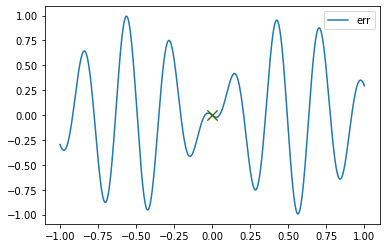

-0.01 0.01


-0.001177060753107071

In [158]:
psi0 = psi(0.0, 1.0)
q = 0.6839999999999999
Delta = 0.0005
Omega01 = 1.0
Omega02 = q*Omega01
t1 = np.pi/(2.0*Omega01)
T = 20.0/Omega01
t2 = 3.0*np.pi/(2.0*Omega01)
tol = 1.0e-10
CS0 = 0.0

pts = 1000
delds = np.linspace(-1.0, 1.0, pts)
errSigPts = [0.0]*pts
for ii in range(pts):
    errSigPts[ii] = HRerrSig(psi0, t1, T, t2, delds[ii], delds[ii]+Delta, Omega01, Omega02)
    
plt.plot(delds,errSigPts, label = "err")
plt.plot([0.0], [0.0], marker="x", color="red", markersize=10)
plt.plot([HRfindRoot(psi0, t1, T, t2, Delta, Omega01, Omega02, tol, CS0)],[0.0], marker="x", color="green", markersize=10)
plt.legend()
plt.show()
HRfindRoot(psi0, t1, T, t2, Delta, Omega01, Omega02, tol, CS0)

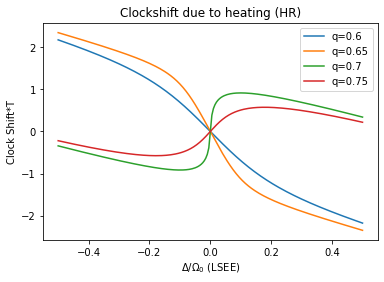

In [187]:
psi0 = psi(0.0, 1.0)
q = 0.9
Omega01 = 1.0
Omega02 = q*Omega01
t1 = np.pi/(2.0*Omega01)
T = 20.0/Omega01
t2 = 3.0*np.pi/(2.0*Omega01)
tol = 1.0e-10

pts = 101 
Deltas = np.linspace(0.0, 0.5, pts)
clockShifts0 = np.zeros(pts,)
clockShifts1 = np.zeros(pts,)
clockShifts2 = np.zeros(pts,)
clockShifts3 = np.zeros(pts,)
cs0 = np.zeros(2*pts,)
cs1 = np.zeros(2*pts,)
cs2 = np.zeros(2*pts,)
cs3 = np.zeros(2*pts,)
CS0 = 0.0
CS1 = 0.0
CS2 = 0.0
CS3 = 0.0

for ii in range(pts):
    #print(Deltas[ii])
    clockShifts0[ii] = T*HRfindRoot(psi0, t1, T, t2, Deltas[ii], Omega01, 0.6*Omega01, tol, CS0)
    CS0 = clockShifts0[ii]/T
    #print(CS0)
    clockShifts1[ii] = T*HRfindRoot(psi0, t1, T, t2, Deltas[ii], Omega01, 0.65*Omega01, tol, CS1)
    CS1 = clockShifts1[ii]/T
    clockShifts2[ii] = T*HRfindRoot(psi0, t1, T, t2, Deltas[ii], Omega01, 0.7*Omega01, tol, CS2)
    CS2 = clockShifts2[ii]/T
    clockShifts3[ii] = T*HRfindRoot(psi0, t1, T, t2, Deltas[ii], Omega01, 0.75*Omega01, tol, CS3)
    CS3 = clockShifts3[ii]/T
    
DeltaPts = np.concatenate((np.flip(-Deltas),Deltas))
cs0 = np.concatenate((np.flip(-clockShifts0), clockShifts0))
cs1 = np.concatenate((np.flip(-clockShifts1), clockShifts1))
cs2 = np.concatenate((np.flip(-clockShifts2), clockShifts2))
cs3 = np.concatenate((np.flip(-clockShifts3), clockShifts3))

plt.plot(DeltaPts, cs0, label="q=0.6")
plt.plot(DeltaPts, cs1, label="q=0.65")
plt.plot(DeltaPts, cs2, label="q=0.7")
plt.plot(DeltaPts, cs3, label="q=0.75")
plt.xlabel("$\Delta / \Omega_0$ (LSEE)")
plt.ylabel('Clock Shift*T')
plt.title("Clockshift due to heating (HR)")
plt.legend()
plt.show()

In [6]:
psi0 = psi(0.0, 1.0)
q = 0.9
Omega01 = 1.0
Omega02 = q*Omega01
t1 = np.pi/(2.0*Omega01)
T = 20.0/Omega01
t2 = 3.0*np.pi/(2.0*Omega01)
tol = 1.0e-10

pts = 101 
Deltas = np.linspace(0.0, 0.5, pts)
clockShifts0 = np.zeros(pts,)
clockShifts1 = np.zeros(pts,)
clockShifts2 = np.zeros(pts,)
clockShifts3 = np.zeros(pts,)
cs0 = np.zeros(2*pts,)
cs1 = np.zeros(2*pts,)
cs2 = np.zeros(2*pts,)
cs3 = np.zeros(2*pts,)
CS0 = 0.0
CS1 = 0.0
CS2 = 0.0
CS3 = 0.0

for ii in range(pts):
    #print(Deltas[ii])
    clockShifts0[ii] = T*HRLongfindRoot(psi0, t1, T, t2, Deltas[ii], Omega01, 0.6*Omega01, tol, CS0)
    CS0 = clockShifts0[ii]/T
    #print(CS0)
    clockShifts1[ii] = T*HRLongfindRoot(psi0, t1, T, t2, Deltas[ii], Omega01, 0.8*Omega01, tol, CS1)
    CS1 = clockShifts1[ii]/T
    clockShifts2[ii] = T*HRLongfindRoot(psi0, t1, T, t2, Deltas[ii], Omega01, 0.9*Omega01, tol, CS2)
    CS2 = clockShifts2[ii]/T
    clockShifts3[ii] = T*HRLongfindRoot(psi0, t1, T, t2, Deltas[ii], Omega01, Omega01, tol, CS3)
    CS3 = clockShifts3[ii]/T
    #print(CS3)
    
DeltaPts = np.concatenate((np.flip(-Deltas),Deltas))
cs0 = np.concatenate((np.flip(-clockShifts0), clockShifts0))
cs1 = np.concatenate((np.flip(-clockShifts1), clockShifts1))
cs2 = np.concatenate((np.flip(-clockShifts2), clockShifts2))
cs3 = np.concatenate((np.flip(-clockShifts3), clockShifts3))

#plt.plot(DeltaPts, cs0, label="q=0.7")
#plt.plot(DeltaPts, cs1, label="q=0.8")
#plt.plot(DeltaPts, cs2, label="q=0.9")
plt.plot(DeltaPts, cs3, label="q=1.0")
plt.xlabel("$\Delta / \Omega_0$ (LSEE)")
plt.ylabel('Clock Shift*T')
plt.title("Clockshift due to heating (HR)")
plt.legend()
plt.show()

-0.0009 0.0009
-0.0009 0.0009
-0.0009 0.0009
-0.0009 0.0009
-0.0009 0.0009
not valid interval


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

-0.01 0.01


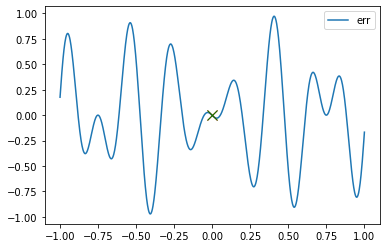

-0.01 0.01


-0.0015927731990814213

In [181]:
psi0 = psi(0.0, 1.0)
q = 0.861
Delta = 0.001
Omega01 = 1.0
Omega02 = q*Omega01
t1 = np.pi/(2.0*Omega01)
T = 20.0/Omega01
t2 = 7.0*np.pi/(2.0*Omega01)
tol = 1.0e-10
CS0 = 0.0

pts = 1000
delds = np.linspace(-1.0, 1.0, pts)
errSigPts = [0.0]*pts
for ii in range(pts):
    errSigPts[ii] = HRerrSig(psi0, t1, T, t2, delds[ii], delds[ii]+Delta, Omega01, Omega02)
    
plt.plot(delds,errSigPts, label = "err")
plt.plot([0.0], [0.0], marker="x", color="red", markersize=10)
plt.plot([HR7findRoot(psi0, t1, T, t2, Delta, Omega01, Omega02, tol, CS0)],[0.0], marker="x", color="green", markersize=10)
plt.legend()
plt.show()
HR7findRoot(psi0, t1, T, t2, Delta, Omega01, Omega02, tol, CS0)

-0.01 0.01
-0.01 0.01
-0.01 0.01
-0.01 0.01
-0.01 0.01
-0.01 0.01
-0.01 0.01
-0.01 0.01
-0.010297246444970369 0.009702753555029631
-0.010975446365773679 0.009024553634226322
-0.00889333289116621 0.01110666710883379
-0.010000039264559746 0.009999960735440254
-0.010594710204750299 0.009405289795249702
-0.011951253842562437 0.008048746157437564
-0.0077947921492159365 0.012205207850784064
-0.010000314004719258 0.009999685995280743
-0.010892608333379029 0.009107391666620971
-0.01292778305709362 0.007072216942906381
-0.00671223573386669 0.01328776426613331
-0.010001059081405401 0.0099989409185946
-0.011191157456487416 0.008808842543512585
-0.013905393742024897 0.006094606257975104
-0.0056530082598328585 0.014346991740167143
-0.010002508210018277 0.009997491789981723
-0.011490573491901157 0.008509426508098843
-0.014884444214403629 0.005115555785596372
-0.004623738508671522 0.015376261491328478
-0.010004893308505416 0.009995106691494584
-0.011791071388870476 0.008208928611129524
-0.01586529096

-0.01998541214503347 1.4587854966531533e-05
-0.04485852964222423 -0.02485852964222423
-0.09723832845687848 -0.07723832845687849
-0.005534089794382458 0.014465910205617542
-0.02030416411347686 -0.0003041641134768607
-0.045620224718004386 -0.025620224718004382
-0.09849924189038554 -0.07849924189038555
-0.005960260592401035 0.014039739407598966
-0.020627554636448612 -0.0006275546364486115
-0.04639216022565953 -0.026392160225659524
-0.09975321781821529 -0.0797532178182153
-0.006390019180253155 0.013609980819746846
-0.020955559313297262 -0.0009555593132972596
-0.04717439553700379 -0.027174395537003786
-0.1009998779371379 -0.0809998779371379
-0.006823286283761269 0.013176713716238731
-0.021288154730573283 -0.0012881547305732821
-0.04796698666177681 -0.027966986661776806
-0.10223886435851437 -0.08223886435851438
-0.00725998772308231 0.01274001227691769
-0.021625318480655534 -0.001625318480655535
-0.0487699859496205 -0.028769985949620498
-0.10346984025090912 -0.08346984025090913
-0.00770005416

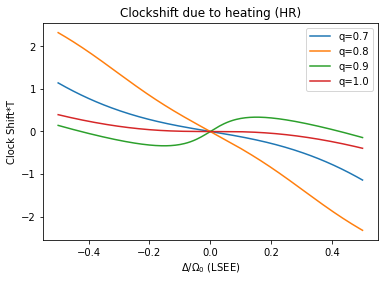

In [173]:
psi0 = psi(0.0, 1.0)
q = 0.9
Omega01 = 1.0
Omega02 = q*Omega01
t1 = np.pi/(2.0*Omega01)
T = 20.0/Omega01
t2 = 7.0*np.pi/(2.0*Omega01)
tol = 1.0e-10

pts = 101 
Deltas = np.linspace(0.0, 0.5, pts)
clockShifts0 = np.zeros(pts,)
clockShifts1 = np.zeros(pts,)
clockShifts2 = np.zeros(pts,)
clockShifts3 = np.zeros(pts,)
cs0 = np.zeros(2*pts,)
cs1 = np.zeros(2*pts,)
cs2 = np.zeros(2*pts,)
cs3 = np.zeros(2*pts,)
CS0 = 0.0
CS1 = 0.0
CS2 = 0.0
CS3 = 0.0

for ii in range(pts):
    #print(Deltas[ii])
    clockShifts0[ii] = T*HR7findRoot(psi0, t1, T, t2, Deltas[ii], Omega01, 0.6*Omega01, tol, CS0)
    CS0 = clockShifts0[ii]/T
    #print(CS0)
    clockShifts1[ii] = T*HR7findRoot(psi0, t1, T, t2, Deltas[ii], Omega01, 0.8*Omega01, tol, CS1)
    CS1 = clockShifts1[ii]/T
    clockShifts2[ii] = T*HR7findRoot(psi0, t1, T, t2, Deltas[ii], Omega01, 0.9*Omega01, tol, CS2)
    CS2 = clockShifts2[ii]/T
    clockShifts3[ii] = T*HR7findRoot(psi0, t1, T, t2, Deltas[ii], Omega01, Omega01, tol, CS3)
    CS3 = clockShifts3[ii]/T
    #print(CS3)
    
DeltaPts = np.concatenate((np.flip(-Deltas),Deltas))
cs0 = np.concatenate((np.flip(-clockShifts0), clockShifts0))
cs1 = np.concatenate((np.flip(-clockShifts1), clockShifts1))
cs2 = np.concatenate((np.flip(-clockShifts2), clockShifts2))
cs3 = np.concatenate((np.flip(-clockShifts3), clockShifts3))

plt.plot(DeltaPts, cs0, label="q=0.7")
plt.plot(DeltaPts, cs1, label="q=0.8")
plt.plot(DeltaPts, cs2, label="q=0.9")
plt.plot(DeltaPts, cs3, label="q=1.0")
plt.xlabel("$\Delta / \Omega_0$ (LSEE)")
plt.ylabel('Clock Shift*T')
plt.title("Clockshift due to heating (HR)")
plt.legend()
plt.show()

In [191]:
isinstance([], float)

False

In [192]:
[]

[]